<a href="https://colab.research.google.com/github/Jayashreehv/NLP-Projects/blob/master/textclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Require Java to install h2o in the next step which works on java
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [4]:
!pip install h2o

     |████████████████████████████████| 129.3MB 91kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.1-py2.py3-none-any.whl size=129358602 sha256=2446b63fe8999809867e15222ffe70264817f000d806f21e3c5f5ab116a3a536
  Stored in directory: /root/.cache/pip/wheels/33/ac/52/165c35d747abdb629c3c9fb7e087f360c662d8cb58824caed8
Successfully built h2o


In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML


In [6]:
h2o.init()
#h2o cluster initialization

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3f1iebfh
  JVM stdout: /tmp/tmp3f1iebfh/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp3f1iebfh/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_up8rel
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [7]:
#punkt is a nltk corpus used for sentence tokenization
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
#Original Dataset is from CFPB Website(Consumer Financial protection Board-governing authority to solve consumer complaints)
df=pd.read_csv(
    'https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true',compression='zip',sep=',',quotechar='"')

In [9]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57448,2/29/2020,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I am attempting to make a payment toward my st...,None,"Nelnet, Inc.",KS,None,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549178
57449,2/11/2020,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,Received letter for {$480.00}. Original credit...,Company has responded to the consumer and the ...,"The Receivable Management Services LLC, New Yo...",AZ,853XX,None,Consent provided,Web,2/18/2020,Closed with explanation,Yes,NaN,3527928
57450,2/29/2020,Debt collection,Other debt,Communication tactics,"Used obscene, profane, or other abusive language",entire time 10 years until XX/XX/2020. XXXX ma...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,8101,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549238
57451,1/16/2020,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I am a customer with Wells Fargo Bank. Recentl...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,852XX,None,Consent provided,Web,1/22/2020,Closed with explanation,Yes,NaN,3498566


In [10]:
# product is a target column, value distribution is found as below
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

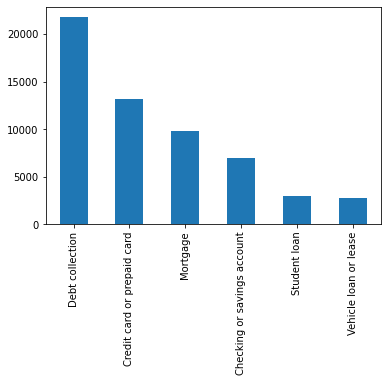

In [11]:
df['Product'].value_counts().plot(kind='bar')

The above bar chart shows highly imbalanced distribution of data

In [12]:
df['Company'].value_counts()

CITIBANK, N.A.                              3226
CAPITAL ONE FINANCIAL CORPORATION           2711
BANK OF AMERICA, NATIONAL ASSOCIATION       2580
JPMORGAN CHASE & CO.                        2409
WELLS FARGO & COMPANY                       2001
                                            ... 
Xtreme Products LLC                            1
RAYMOND JAMES BANK, NATIONAL ASSOCIATION       1
RELIANCE FIRST CAPITAL LLC                     1
BAYSIDE CREDIT                                 1
FIRST HOME MORTGAGE CORPORATION                1
Name: Company, Length: 2197, dtype: int64

In [13]:
#Selecting only 3 required features for analysis and renaming the lengthy column
complaints_df=df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})

In [14]:

pd.set_option('display.max_colwidth',-1)
complaints_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,complaints,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never

In [15]:
#Displaying categories present in Product column (which is our target column)
complaints_df['Product'].unique()


array(['Vehicle loan or lease', 'Debt collection',
       'Checking or savings account', 'Mortgage',
       'Credit card or prepaid card', 'Student loan'], dtype=object)

In [16]:
#encoding the categories of target column (Creating dictionary)
target={'Debt collection':0,'Credit card or prepaid card':1,'Mortgage':2,'Checking or savings account':3,'Student loan':4,'Vehicle loan or lease':5}

In [17]:
#Creating target column and copying Product column as target column by mapping each category to encoded values present in dictionary named target
complaints_df['target']=complaints_df['Product'].map(target)

In [18]:
complaints_df

,complaints,Product,Company,target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked

In [19]:
X_train,X_test=train_test_split(complaints_df,test_size=0.2,random_state=43)

In [20]:
#Stemming
stemmer=nltk.stem.SnowballStemmer('english')

In [21]:
nltk.download('stopwords')
stop_words=set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
#Writing user defined function to remove few redundant words and creating tokens, converting to lowercase and then do stemming operation
def tokenize(text):
  tokens=[word for word in nltk.word_tokenize(text) if (len(word)>3 and len(word.strip('Xx/'))>2 and len(re.sub('\d+','',word.strip('Xx/')))>2)]
  tokens=map(str.lower,tokens)
  stems=[stemmer.stem(item) for item in tokens if (item not in stop_words)]
  return stems


In [23]:
#Use tfvectorizer and pass userdefined function to get add more flexibility 
#tokenizer is assigned to usefdefined function tokenize, stop_words set to none as it is already considered in tokenize function, max_df=0.75 indicates consider the words if appeared in morethan 75% of the document more than that if it appears then it is redundant or common, lowercase is false as it is already done in tokenize function, ngram is 1,2, max_features=1000 since sparse vector is created good to have more features
vectorizer_tf=TfidfVectorizer(tokenizer=tokenize,stop_words=None,max_df=0.75,max_features=1000,lowercase=False,ngram_range=(1,2))
train_vectors=vectorizer_tf.fit_transform(X_train.complaints)

In [24]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.07243871,
        0.03908569],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [25]:
train_vectors

<45962x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2350412 stored elements in Compressed Sparse Row format>

In [26]:
vectorizer_tf.get_feature_names()

['abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account bank',
 'account call',
 'account close',
 'account credit',
 'account inform',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amex',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 'arrang',
 'arriv',
 'ask',
 'ask speak',
 'assess',
 'assign',
 'ass

In [27]:
X_train.shape

(45962, 4)

In [28]:
test_vectors=vectorizer_tf.transform(X_test.complaints)

In [29]:
train_df=pd.DataFrame(train_vectors.toarray(),columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)],axis=1)

In [30]:
train_df

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,agenc,...,verifi,victim,victim ident,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.170482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.068816,0.070800,0.0,0.0,0.0,0.0,0.0,0.0,0.047876,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.042932,0.0,0.175766,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.044524,0.061189,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.051036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.148865,0.000000,0.000000,0.0,0.0,0.000000,0.128223,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.072974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078535,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.052753,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.085759,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.059717,0.0,0.072439,0.039086,0
3,0.0,0.088926,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.129242,0.0,0.0,0.0,0.0,0.0,0.0,0.174789,0.0,0.0,0.0,0.0,0.0,0.101309,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.055849,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45957,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.108951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0
45958,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.104717,0.138435,0.0,0.0,0.000000,0.000000,0.0,0.0,0

In [31]:
test_df=pd.DataFrame(test_vectors.toarray(),columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)],axis=1)
test_df

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,agenc,...,verifi,victim,victim ident,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.058762,0.000000,0.0,0.0,0.00000,0.0,0.117512,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.094042,0.0,0.0,0.000000,0.000000,0.051788,0.0,0.070673,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.073809,0.000000,0.146684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3
1,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.154278,0.0,0.248567,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.151638,0.0,0.0,0.0,0.0,0.0,0.000000,0.212346,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.145817,0.216701,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123950,1
2,0.0,0.045960,0.000000,0.0,0.0,0.05598,0.0,0.114889,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167834,0.058134,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.061695,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0666,0.0,0.0,0.048265,0.063806,0.043715,0.000000,0.000000,0.028865,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3
3,0.0,0.063849,0.000000,0.0,0.0,0.00000,0.0,0.063842,0.0,0.000000,0.0,0.0,0.085032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.143053,0.000000,0.000000,0.0,0.153583,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.058357,0.040100,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
4,0.0,0.081273,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.083206,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.079903,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.168190,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.153306,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.059297,0.0,0.000000,0.000000,0.063586,0.094497,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.070657,0.000000,0.000000,0.108302,0.000000,0.084512,0.105941,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3
11487,0.0,0.000000,0.061535,0.0,0.0,0.00000,0.0,0.039800,0.0,0.000000,0.0,0.0,0.053009,0.0,0.0,0.0,0.0,0.0

In [32]:
#converting to h2o dataframe
h2o_train_df=h2o.H2OFrame(train_df)
h2o_test_df=h2o.H2OFrame(test_df)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [33]:
h2o_train_df.types

{'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'accord': 'real',
 'account': 'real',
 'account account': 'real',
 'account balanc': 'real',
 'account bank': 'real',
 'account call': 'real',
 'account close': 'real',
 'account credit': 'real',
 'account inform': 'real',
 'account number': 'real',
 'account open': 'real',
 'account report': 'real',
 'account would': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'act': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advantag': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': 'real',
 'agent': 'real',
 'agre': 'real',
 'agreement': 'real',
 'alert': 'real',
 'alleg': 'real',
 'alleg debt': 'real',
 'alli': 'real',
 'allow': 'real',
 'almost': 'real'

In [34]:
#The target columns is encoded as int values, h2o must not consider it for regression model so converting the type as enumerated object
h2o_train_df['target']=h2o_train_df['target'].asfactor()
h2o_test_df['target']=h2o_test_df['target'].asfactor()


In [35]:
#Setting H2o AUTOML Pipeline

In [36]:
#max_after_balance size is 0.3 to down sample the majority class if we give above 1 it is for up sampling minority classes
aml=H2OAutoML(max_models=10,seed=10,exclude_algos=["Stackedensemble"],verbosity="info",nfolds=0,balance_classes=True,max_after_balance_size=0.3)

In [37]:
x=vectorizer_tf.get_feature_names()
y='target'

In [38]:
aml.train(x=x,y=y,training_frame=h2o_train_df,validation_frame=h2o_test_df)

AutoML progress: |
04:26:44.726: Project: AutoML_20200830_42644712
04:26:44.727: Cross-validation disabled by user: no fold column nor nfolds > 1.
04:26:44.738: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
04:26:44.738: Build control seed: 10
04:26:44.739: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
04:26:50.775: training frame: Frame key: automl_training_py_1_sid_8632    cols: 1001    rows: 41252  chunks: 53    size: 34370862  checksum: -3280433833830162789
04:26:50.779: validation frame: Frame key: py_2_sid_8632    cols: 1001    rows: 11491  chunks: 14    size: 9571661  checksum: 4850931574861514089
04:26:51.100: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_8632    cols: 1001    rows: 4710  chunks: 53    size: 7522486  checksum: -5825928158973411165
04:26:51.100: blending frame: NULL
04:26:51.100: response 

In [39]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20200830_042644,0.144032,0.311153,0.299716,0.08983
GBM_4_AutoML_20200830_042644,0.15373,0.373446,0.329984,0.108889
XGBoost_2_AutoML_20200830_042644,0.154232,0.324957,0.306222,0.0937717
XGBoost_3_AutoML_20200830_042644,0.158051,0.334307,0.317172,0.100598
GBM_2_AutoML_20200830_042644,0.16166,0.373107,0.332983,0.110878
GBM_5_AutoML_20200830_042644,0.163181,0.3568,0.323953,0.104946
GBM_3_AutoML_20200830_042644,0.16457,0.379997,0.336968,0.113547
GBM_1_AutoML_20200830_042644,0.173301,0.405177,0.350793,0.123056
GLM_1_AutoML_20200830_042644,0.176701,0.371566,0.329443,0.108533
DRF_1_AutoML_20200830_042644,0.298724,0.591961,0.443776,0.196938


In [40]:
predict=aml.leader.predict(h2o_test_df)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [42]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.09496297100673597
RMSE: 0.3081606253348016
LogLoss: 0.3285472121722351
Mean Per-Class Error: 0.14923076624832807

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,3968.0,150.0,67.0,39.0,30.0,47.0,0.077424,"333 / 4,301"
1,183.0,2364.0,15.0,91.0,9.0,13.0,0.116262,"311 / 2,675"
2,63.0,29.0,1846.0,13.0,8.0,16.0,0.065316,"129 / 1,975"
3,44.0,122.0,10.0,1218.0,3.0,5.0,0.131241,"184 / 1,402"
4,68.0,16.0,24.0,0.0,503.0,14.0,0.195200,122 / 625
5,87.0,28.0,28.0,9.0,7.0,354.0,0.309942,159 / 513
6,4413.0,2709.0,1990.0,1370.0,560.0,449.0,0.107736,"1,238 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.892264
1,2,0.965886
2,3,0.983813
3,4,0.994082
4,5,0.998085
5,6,1.000000


In [45]:
model_ids=list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out=h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])


In [46]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20200830_042644


Model Summary: 


,,number_of_trees
0,,105.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.032026639676093184
RMSE: 0.17895988286790193
LogLoss: 0.11884479891137449
Mean Per-Class Error: 0.03921846345723059

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,15393.0,135.0,53.0,33.0,15.0,21.0,0.016422,"257 / 15,650"
1,211.0,9174.0,12.0,66.0,1.0,6.0,0.031257,"296 / 9,470"
2,67.0,51.0,6913.0,13.0,4.0,5.0,0.019850,"140 / 7,053"
3,54.0,65.0,9.0,4884.0,0.0,3.0,0.026122,"131 / 5,015"
4,54.0,45.0,7.0,1.0,1973.0,1.0,0.051898,"108 / 2,081"
5,99.0,64.0,6.0,4.0,5.0,1805.0,0.089763,"178 / 1,983"
6,15878.0,9534.0,7000.0,5001.0,1998.0,1841.0,0.026908,"1,110 / 41,252"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.973092
1,2,0.993479
2,3,0.997770
3,4,0.999467
4,5,0.999879
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.09496297100673597
RMSE: 0.3081606253348016
LogLoss: 0.3285472121722351
Mean Per-Class Error: 0.14923076624832807

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,3968.0,150.0,67.0,39.0,30.0,47.0,0.077424,"333 / 4,301"
1,183.0,2364.0,15.0,91.0,9.0,13.0,0.116262,"311 / 2,675"
2,63.0,29.0,1846.0,13.0,8.0,16.0,0.065316,"129 / 1,975"
3,44.0,122.0,10.0,1218.0,3.0,5.0,0.131241,"184 / 1,402"
4,68.0,16.0,24.0,0.0,503.0,14.0,0.195200,122 / 625
5,87.0,28.0,28.0,9.0,7.0,354.0,0.309942,159 / 513
6,4413.0,2709.0,1990.0,1370.0,560.0,449.0,0.107736,"1,238 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.892264
1,2,0.965886
2,3,0.983813
3,4,0.994082
4,5,0.998085
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2020-08-30 04:26:51,0.088 sec,0.0,0.833333,1.791759,0.829026,0.833333,1.791759,0.828126
1,,2020-08-30 04:27:05,14.270 sec,5.0,0.465821,0.645202,0.123849,0.481230,0.685277,0.146811
2,,2020-08-30 04:27:11,19.549 sec,10.0,0.360142,0.419851,0.104237,0.389143,0.484196,0.134366
3,,2020-08-30 04:27:16,25.163 sec,15.0,0.316649,0.328923,0.090517,0.357376,0.414944,0.128274
4,,2020-08-30 04:27:21,29.688 sec,20.0,0.293255,0.283718,0.080699,0.342705,0.384450,0.122183
5,,2020-08-30 04:27:26,34.727 sec,25.0,0.277797,0.255748,0.073863,0.334124,0.367133,0.118528
6,,2020-08-30 04:27:31,39.894 sec,30.0,0.265761,0.235571,0.067827,0.328817,0.357120,0.116439
7,,2020-08-30 04:27:37,45.907 sec,35.0,0.254845,0.218124,0.062639,0.324806,0.350187,0.114350
8,,2020-08-30 04:27:42,51.151 sec,40.0,0.246070,0.204970,0.057670,0.321789,0.344683,0.113480
9,,2020-08-30 04:27:47,56.185 sec,45.0,0.238621,0.193940,0.053937,0.319606,0.341414,0.112958



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,debt,15425.161133,1.000000,0.102012
1,mortgag,13805.777344,0.895017,0.091302
2,card,9736.001953,0.631177,0.064388
3,loan,6875.568359,0.445737,0.045470
4,bank,6537.963379,0.423851,0.043238
5,credit card,4857.786621,0.314926,0.032126
6,collect,3966.003662,0.257113,0.026229
7,payment,3742.531982,0.242625,0.024751
8,deposit,3389.100586,0.219712,0.022413
9,credit,3294.997070,0.213612,0.021791



See the whole table with table.as_data_frame()


In [48]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'gpu_id': 0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_bin': 256,
  'max_delta_step': 0.0,
  'max_depth': 10,
  'min_child_weight': 5.0,
  'nround': 10000,
  'nthread': 2,
  'num_class': 6,
  'objective': 'multi:softprob',
  'seed': 10,
  'silent': True,
  'subsample': 0.6,
  'updater': 'grow_gpu_hist'},
 10000)

In [50]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix

In [51]:
xgb_clf=xgb.XGBClassifier(n_estimators=100,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10,**{"updater":"grow_gpu"})

In [52]:
xgb_clf.fit(train_vectors,X_train['target'])

[05:50:09] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [53]:
predictions=xgb_clf.predict(test_vectors)

In [54]:
cm=confusion_matrix(X_test['target'],predictions)

In [55]:
print(cm)

[[3916  172   77   51   36   49]
 [ 263 2288   10  103    3    8]
 [  98   35 1798   20    7   17]
 [  74  128   11 1178    3    8]
 [  84   27   30    1  473   10]
 [ 108   37   30    8    5  325]]


In [56]:
print("Classification Report:\n",classification_report(X_test['target'],predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89      4301
           1       0.85      0.86      0.85      2675
           2       0.92      0.91      0.91      1975
           3       0.87      0.84      0.85      1402
           4       0.90      0.76      0.82       625
           5       0.78      0.63      0.70       513

    accuracy                           0.87     11491
   macro avg       0.86      0.82      0.84     11491
weighted avg       0.87      0.87      0.87     11491



In [68]:
from sklearn.utils import class_weight
class_weights=list(class_weight.compute_class_weight('balanced',np.unique(X_train['target']),X_train['target']))

In [69]:
class_weights

[0.43845992406464046,
 0.7283070292197503,
 0.9790814587593729,
 1.3676724394453372,
 3.2947670250896057,
 3.4459439196281303]

In [70]:
weights=np.ones(X_train.shape[0],dtype='float')

In [71]:
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [72]:
for i,val in enumerate(X_train['target']):
  weights[i]=class_weights[val]

In [73]:
weights


array([0.72830703, 0.72830703, 0.43845992, ..., 0.43845992, 0.72830703,
       0.43845992])

In [74]:
xgb_clf=xgb.XGBClassifier(n_estimators=100,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10,**{"updater":"grow_gpu"})

In [75]:
xgb_clf.fit(train_vectors,X_train['target'],sample_weight=weights)

[05:54:20] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [76]:
predictions=xgb_clf.predict(test_vectors)

In [77]:
cm=confusion_matrix(X_test['target'],predictions)
print(cm)

[[3639  204   81  123   84  170]
 [ 160 2204   11  189    7  104]
 [  44   13 1763   30   58   67]
 [  31   90    8 1239    8   26]
 [  31    3    7    2  528   54]
 [  45   10   10   12   17  419]]


In [78]:
print("Classification Report:\n",classification_report(X_test['target'],predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      4301
           1       0.87      0.82      0.85      2675
           2       0.94      0.89      0.91      1975
           3       0.78      0.88      0.83      1402
           4       0.75      0.84      0.80       625
           5       0.50      0.82      0.62       513

    accuracy                           0.85     11491
   macro avg       0.79      0.85      0.81     11491
weighted avg       0.87      0.85      0.86     11491

